In [1]:
import torch
import torchvision
import numpy as np
from utils import *
import time
import os
import random
import torch.nn as nn
from models import *
from dataset import *
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/cs231n/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# change the path for different experiments
flow_path = "data/flow_mul"
label_path = "data/label_mul"
batch_size = 16
down_sample_rate = 1
all_data = FlowSpeedData_new(flow_path, label_path, down_sample_rate)

In [5]:
train_set_size = int(len(all_data)*0.8)
val_set_size = len(all_data) - train_set_size
torch.manual_seed(10086)
train_set, val_set = torch.utils.data.random_split(all_data, [train_set_size, val_set_size])
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [6]:
a = next(iter(train_dataloader))
flow_size = a[0].shape[2:]
label_size = a[1].shape
flow_size

torch.Size([160, 320])

In [7]:
epochs = 50
lr = 1e-5
reg = 1e-3
eps = 1e-6
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
model = OpticalFlowRegression(flow_size)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg, eps=eps)
loss_fn = torch.nn.MSELoss()

In [9]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    
    print("Epoch", str(epoch + 1) + ": ", end="")
    running_tloss = 0.0
    
    model.train(True)
    for i, (flow, label) in enumerate(train_dataloader):
        flow = flow.to(device)
        label = label.to(device).to(torch.float32)
        
        
        optimizer.zero_grad()
        output = model(flow)
        
        
        loss = loss_fn(output, label).to(torch.float32)
        
        loss.backward()
        optimizer.step()
        
        running_tloss += loss.item()

    train_loss = running_tloss / (i+1)
        
    model.train(False)

    running_vloss = 0.0
    for i, (vflow, vlabel) in enumerate(val_dataloader):
        vflow = vflow.to(device)
        vlabel = vlabel.to(device).to(torch.float32)
        voutput = model(vflow)
        vloss = loss_fn(voutput, vlabel)
        running_vloss += vloss.item()

    val_loss = running_vloss / (i+1)
        
        
    print(f'Train Loss: {train_loss}. Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch 1: 

/home/ubuntu/anaconda3/envs/cs231n/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Loss: 245.0687498474121. Validation Loss: 214.87485137939453
Epoch 2: Train Loss: 208.47818145751953. Validation Loss: 207.23600158691406
Epoch 3: Train Loss: 202.1402066040039. Validation Loss: 203.97315368652343
Epoch 4: Train Loss: 199.08144981384277. Validation Loss: 203.45779541015625
Epoch 5: Train Loss: 195.31970802307129. Validation Loss: 200.50635986328126
Epoch 6: Train Loss: 193.87405921936036. Validation Loss: 198.83032836914063
Epoch 7: Train Loss: 191.90367324829103. Validation Loss: 197.66053619384766
Epoch 8: Train Loss: 190.9718653869629. Validation Loss: 197.0035549926758
Epoch 9: Train Loss: 188.84541900634767. Validation Loss: 197.95834655761718
Epoch 10: Train Loss: 189.53880043029784. Validation Loss: 197.0326721191406
Epoch 11: Train Loss: 187.17716403961182. Validation Loss: 196.27962615966797
Epoch 12: Train Loss: 186.94858417510986. Validation Loss: 195.07263916015626
Epoch 13: Train Loss: 185.50701641082765. Validation Loss: 194.79673065185546
Epoch 14:

In [10]:
results = {
    "train_losses" : train_losses,
    "val_losses" : val_losses,
    "epochs" : epochs,
    "lr" : lr,
    "reg" : reg,
    "eps" : eps, 
    "down_sample_rate" : down_sample_rate,
    "batch_size" : batch_size
}

# Change the saving paths
results_path = "results_new/mul_video.txt"
model_path = "results_new/mul_video.pt"
torch.save(results, results_path)
torch.save(model.state_dict(), model_path)

In [11]:
model.eval()
vdata = next(iter(val_dataloader))
vflow = vdata[0].to(device)
vlabel = vdata[1].to(device)
pred = model(vflow)
pred_loss = loss_fn(pred, vlabel)
print(pred_loss.item())

174.6301081994324


In [12]:
pred

tensor([[30.0023],
        [19.0009],
        [21.6374],
        [ 7.2449],
        [14.0638],
        [17.7579],
        [19.7703],
        [25.2506],
        [14.9600],
        [13.6628],
        [16.0398],
        [ 5.5069],
        [ 9.0605],
        [ 3.8663],
        [ 3.8430],
        [11.7153]], device='cuda:0', grad_fn=<SqrtBackward0>)

In [13]:
vlabel

tensor([13.5715, 30.7948,  7.9212, 13.6738,  4.4549, 30.2688, 32.1445, 26.3566,
        13.1949, 29.9149, 18.0765, 23.1288, -0.5514, 22.9249, 11.6206, 28.5075],
       device='cuda:0', dtype=torch.float64)

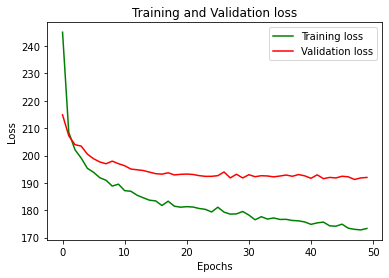

In [14]:
plt.plot(range(epochs), train_losses, 'g', label = "Training loss")
plt.plot(range(epochs), val_losses, 'r', label = "Validation loss")
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [15]:
def accuracy_geo(pred, label):
    return torch.pow(torch.prod(pred / label), 1 / len(pred)).item()
def accuracy_perc(pred, label):
    return torch.mean(torch.abs(pred - label)/torch.abs(label))

In [17]:
accuracy_geo(pred, vlabel)

0.08876544777085361